In [1]:
import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras import layers, models, Model
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import History
from keras.utils import plot_model

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

!pip install visualkeras
import visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 16.9 MB/s eta 0:00:00


In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 32, 32)


In [3]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


In [4]:
def datagenerator(x1, x2, batchsize):
    n1, n2 = x1.shape[0], x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)
        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])
        yield x_data, y_data

In [5]:
# Create evaluation generator
testgen = datagenerator(mnist_x_test, fashion_mnist_x_test, 5000)
eval_samples_x, (eval_samples_y1, eval_samples_y2) = next(testgen)

def eval_model(model):
    x, (y1, y2) = next(testgen)
    # use model.predict to get predictions. Here we just call model
    pred1, pred2 = model.predict(x)  #added predict as suggested
    return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2)) / 2  # ATTENTION: modified the position of the division for a correct mean

# Model

### **U-Net Architecture**
This U-Net model follows an encoder-decoder structure with skip connections, well suited for this type of tasks.  

#### Architecture

1. **Input & Reshape**: The `(32,32)` grayscale input is reshaped to `(32,32,1)` for compatibility with `Conv2D`.  
2. **Encoder**: Three convolutional blocks, each with:  
   - Two `Conv2D` layers (`ReLU` activation)  
   - `BatchNormalization` (after activation)  
   - `MaxPooling2D` (downsampling)  
   - Filters start at `64`, doubling at each step.  
3. **Bottleneck**: Two `Conv2D` layers (`ReLU` + `BatchNormalization`), extracting deep features.  
4. **Decoder**: Mirrors the encoder using `Conv2DTranspose` (upsampling) + skip connections for detail recovery.  
5. **Output**: A shared `Conv2D(8)` layer branches into two `1x1 Conv2D` layers (`sigmoid` activation), reshaped back to `(32,32)`.  

#### Key Design Choices  
- **Reshape**: Ensures compatibility with `Conv2D` and maintains original dimensions in output, without the need of a "squeeze" later on.  
- **Activation in `Conv2D`**: By adding the  activation function in the Conv2D layer, I avoid to use an extra layer for the activation itself.  
- **Skip Connections**: Prevent information loss, improving separation performance.  

In [6]:
def build_unet(input_shape=(32, 32), initial_filters=64, n_layers=3):
    inputs = layers.Input(input_shape)
    x = layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)
    skip_connections = []
    current_filters = initial_filters

    # Encoder
    for _ in range(n_layers):
        x = layers.Conv2D(current_filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(current_filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        skip_connections.append(x)
        x = layers.MaxPooling2D((2, 2))(x)
        current_filters *= 2

    # Bottleneck
    x = layers.Conv2D(current_filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(current_filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Decoder
    for skip in reversed(skip_connections):
        current_filters //= 2
        x = layers.Conv2DTranspose(current_filters, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(current_filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(current_filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    shared = layers.Conv2D(8, (3, 3), padding='same', activation='relu')(x)

    output1 = layers.Conv2D(1, (1, 1), activation='sigmoid')(shared)
    output2 = layers.Conv2D(1, (1, 1), activation='sigmoid')(shared)

    output1 = layers.Reshape(input_shape)(output1)
    output2 = layers.Reshape(input_shape)(output2)

    model = models.Model(inputs, [output1, output2])

    return model

model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 32, 32, 1)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 256)      │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 256)      │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 4, 4, 256)      │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 4, 4, 512)      │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 4, 4, 512)      │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 8,566,554 (32.68 MB)

 Trainable params: 8,563,738 (32.67 MB)

 Non-trainable params: 2,816 (11.00 KB)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


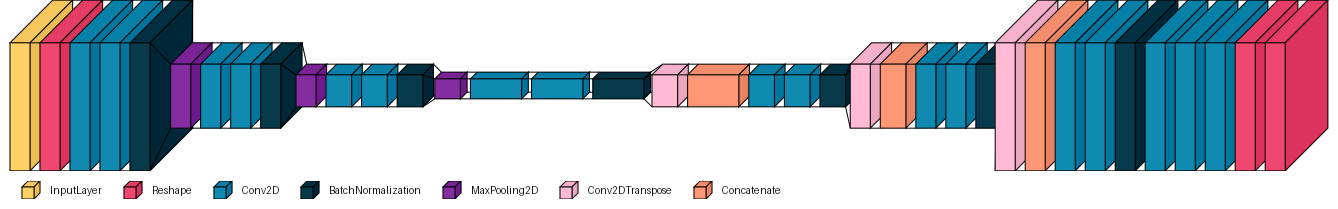

In [7]:
visualkeras.layered_view(model, legend=True)

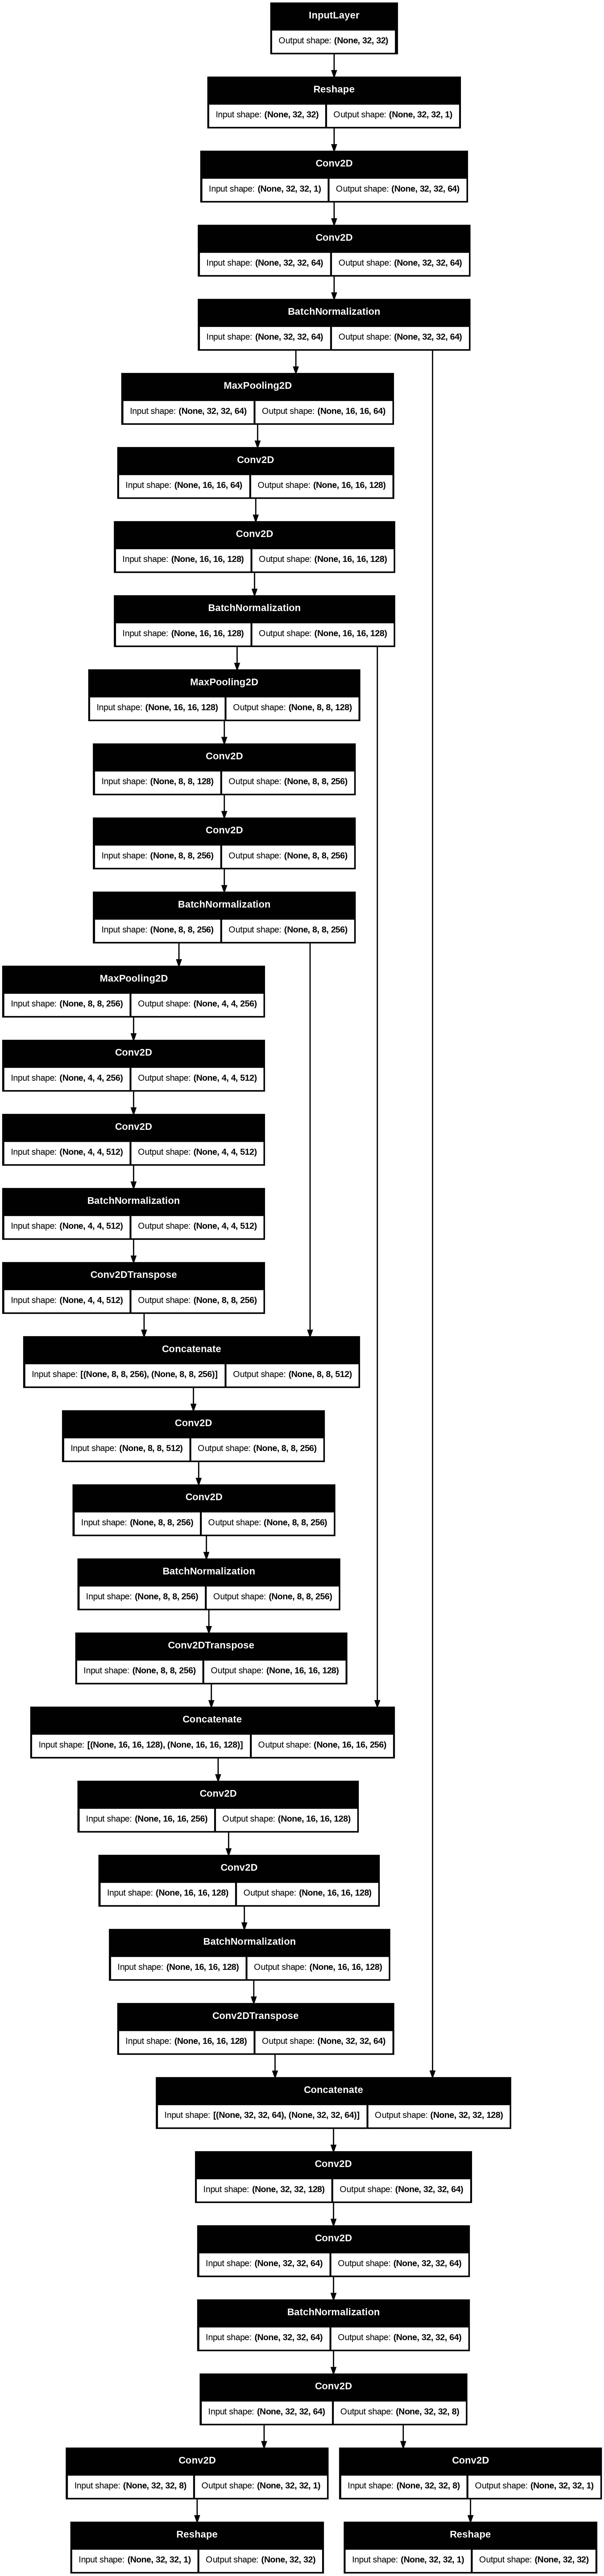

In [8]:
plot_model(model=model, to_file='unet.png', show_shapes=True)

# Training

- ReduceLROnPlateau: Lowers the learning rate by a factor of 0.2 if validation loss stagnates for 5 epochs, preventing overfitting and improving convergence.
- EarlyStopping: Stops training if validation loss doesn't improve for 15 epochs, restoring the best weights to avoid unnecessary overtraining.
- Adam Optimizer (LR = 1e-3): Adaptive learning rate optimization for stable and efficient training.
- Batch Size & Steps: Uses batch size 128 and steps based on dataset size for efficient training.

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.2,
  patience=5,
  min_lr=1e-6,
  verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=15,
  restore_best_weights=True,
  verbose=1
)

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss=['mse', 'mse'],
  metrics=[['mse'], ['mse']]
)

    # Store callbacks as a model property for easy access
model.callbacks = [reduce_lr, early_stopping]

In [10]:
history = model.fit(
    datagenerator(mnist_x_train, fashion_mnist_x_train, 128),
    steps_per_epoch=mnist_x_train.shape[0] // 32,
    epochs=30,
    validation_data=datagenerator(mnist_x_test, fashion_mnist_x_test, 128),
    validation_steps=mnist_x_test.shape[0] // 32,
    callbacks=model.callbacks,
    verbose=1
)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 253s 121ms/step - loss: 0.0146 - reshape_1_loss: 0.0086 - reshape_1_mse: 0.0086 - reshape_2_loss: 0.0060 - reshape_2_mse: 0.0060 - val_loss: 0.0025 - val_reshape_1_loss: 0.0011 - val_reshape_1_mse: 0.0011 - val_reshape_2_loss: 0.0014 - val_reshape_2_mse: 0.0014 - learning_rate: 0.0010
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 258s 138ms/step - loss: 0.0023 - reshape_1_loss: 0.0010 - reshape_1_mse: 0.0010 - reshape_2_loss: 0.0012 - reshape_2_mse: 0.0012 - val_loss: 0.0021 - val_reshape_1_loss: 0.0010 - val_reshape_1_mse: 0.0010 - val_reshape_2_loss: 0.0011 - val_reshape_2_mse: 0.0011 - learning_rate: 0.0010
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 228s 122ms/step - loss: 0.0018 - reshape_1_loss: 8.1261e-04 - reshape_1_mse: 8.1261e-04 - reshape_2_loss: 9.4357e-04 - reshape_2_mse: 9.4357e-04 - val_loss: 0.0018 - val_reshape_1_loss: 8.8935e-04 - val_reshape_1_mse: 8.8935e-04 - val_reshape_2_loss: 8.9803e-04 - val_reshape_2_mse: 8.9803e-04 - learni

In [32]:
def plot_training_history(history):
    plt.figure(figsize=(10, 6))

    # Plot learning rate, training loss, and validation loss
    plt.plot(history.history['learning_rate'], label='Learning Rate', linestyle='-', marker='s')
    plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='s')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-', marker='s')

    # Calculate merged values for reshape_1_mse and reshape_2_mse
    merged_mse = [(x + y) / 2 for x, y in zip(history.history['reshape_1_mse'], history.history['reshape_2_mse'])]
    merged_val_mse = [(x + y) / 2 for x, y in zip(history.history['val_reshape_1_mse'], history.history['val_reshape_2_mse'])]

    # Plot merged MSE values
    plt.plot(merged_mse, label='Merged Training MSE (reshape_1 & reshape_2)', linestyle='-', marker='o')
    plt.plot(merged_val_mse, label='Merged Validation MSE (reshape_1 & reshape_2)', linestyle='-', marker='o')

    plt.xlabel('Epoch')
    plt.ylabel('Loss / MSE')
    plt.title('Training and Validation Loss / MSE Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.show()

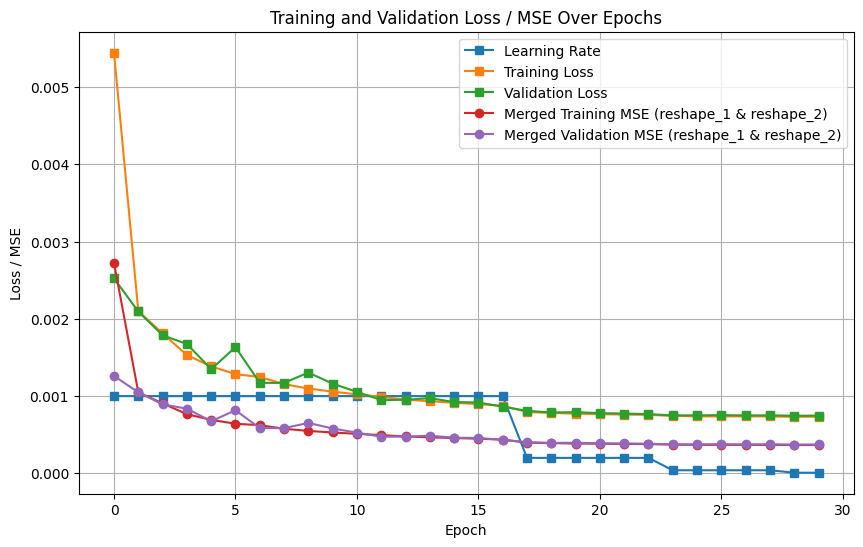

In [35]:
plot_training_history(history)

In [11]:
#optional for saving/loading the model weights
model.save_weights("model_30_epochs.weights.h5")
#model.load_weights("/content/model_30_epochs.weights.h5")

In order to avoid google colab free tier limitation I divided the training in two separate parts, as a checkpoint, however we can see that in the second training, also considering tailored callbacks, there is no significant gain for the loss function.

In [17]:
#new callbacks for 2nd training batch
reduce_lr2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,  # here I reduced patience
    min_lr=1e-6,
    verbose=1
)

early_stopping2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # here I reduced patience
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=['mse', 'mse'],
    metrics=[['mse'], ['mse']]
)

model.callbacks2 = [reduce_lr2, early_stopping2]

In [18]:
#another 20 epochs
history2 = model.fit(
    datagenerator(mnist_x_train, fashion_mnist_x_train, 128),
    steps_per_epoch=mnist_x_train.shape[0] // 32,
    epochs=20, # here I reduced the epochs since it was pointless to keep training
    validation_data=datagenerator(mnist_x_test, fashion_mnist_x_test, 128),
    validation_steps=mnist_x_test.shape[0] // 32,
    callbacks=model.callbacks2,
    verbose=1
)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 245s 123ms/step - loss: 8.0971e-04 - reshape_1_loss: 3.9365e-04 - reshape_1_mse: 3.9365e-04 - reshape_2_loss: 4.1606e-04 - reshape_2_mse: 4.1606e-04 - val_loss: 8.2576e-04 - val_reshape_1_loss: 4.1403e-04 - val_reshape_1_mse: 4.1403e-04 - val_reshape_2_loss: 4.1173e-04 - val_reshape_2_mse: 4.1173e-04 - learning_rate: 0.0010
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 261s 139ms/step - loss: 8.2980e-04 - reshape_1_loss: 4.0365e-04 - reshape_1_mse: 4.0365e-04 - reshape_2_loss: 4.2615e-04 - reshape_2_mse: 4.2615e-04 - val_loss: 8.9409e-04 - val_reshape_1_loss: 4.0733e-04 - val_reshape_1_mse: 4.0733e-04 - val_reshape_2_loss: 4.8676e-04 - val_reshape_2_mse: 4.8676e-04 - learning_rate: 0.0010
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 262s 140ms/step - loss: 8.2885e-04 - reshape_1_loss: 4.0377e-04 - reshape_1_mse: 4.0377e-04 - reshape_2_loss: 4.2508e-04 - reshape_2_mse: 4.2508e-04 - val_loss: 8.7132e-04 - val_reshape_1_loss: 4.2151e-04 - val_reshape_1_m

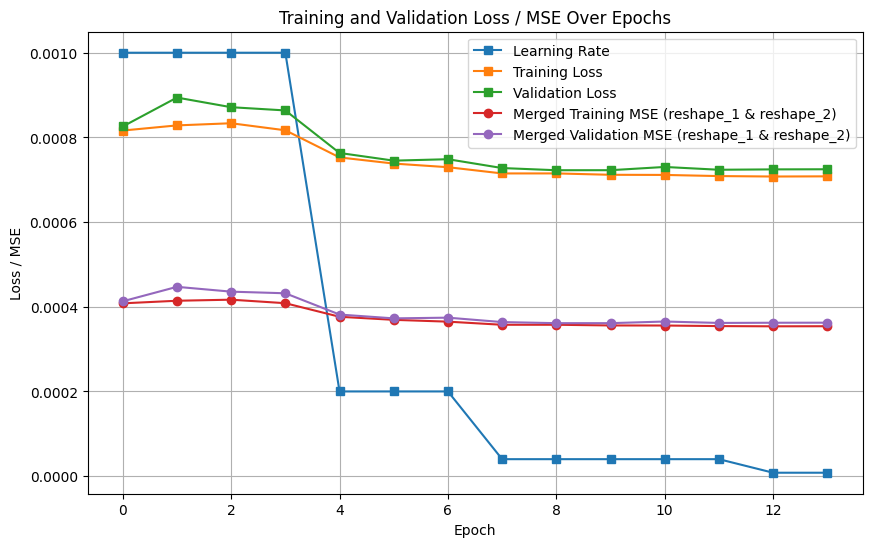

In [34]:
plot_training_history(history2)

In [36]:
#optional for saving/loading the model weights
model.save_weights("model_50_epochs.weights.h5")
#model.load_weights("/content/model_50_epochs_consegna1.weights.h5")

In [39]:
# Evaluate model
print("\nModel Evaluation:")
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))

print("MSE = ", np.mean(eval_results))
print("Standard Deviation = ", np.std(eval_results))


Model Evaluation:
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
MSE =  0.0003626178223305065
Standard Deviation =  5.106701318281545e-06


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


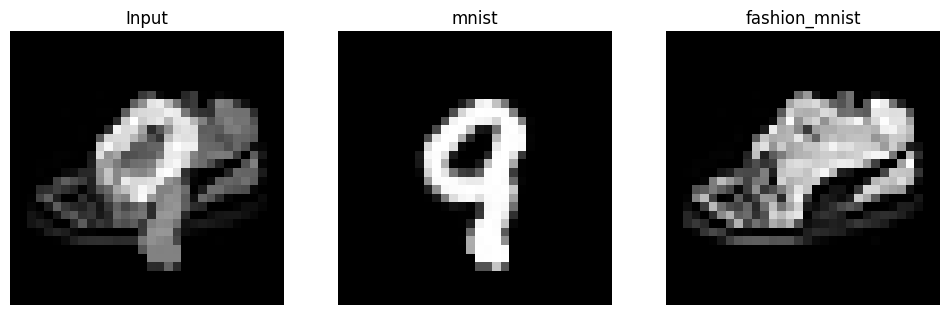

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


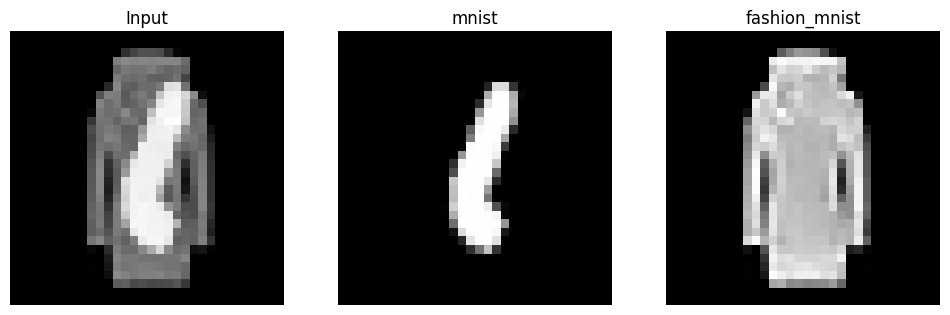

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


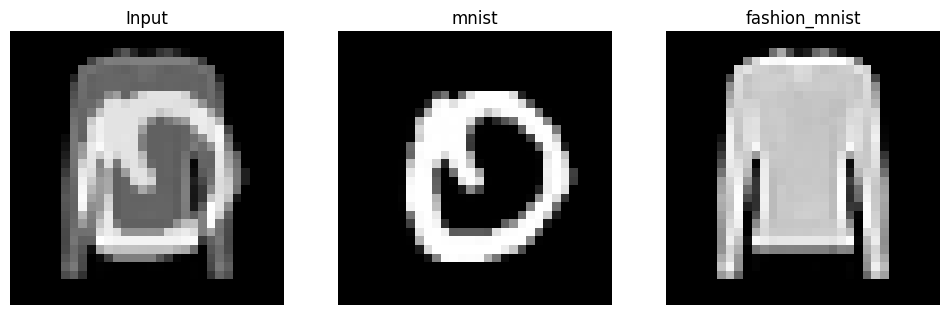

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


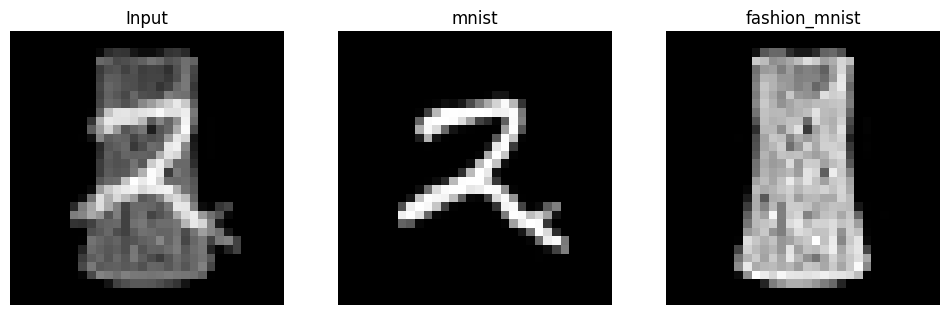

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


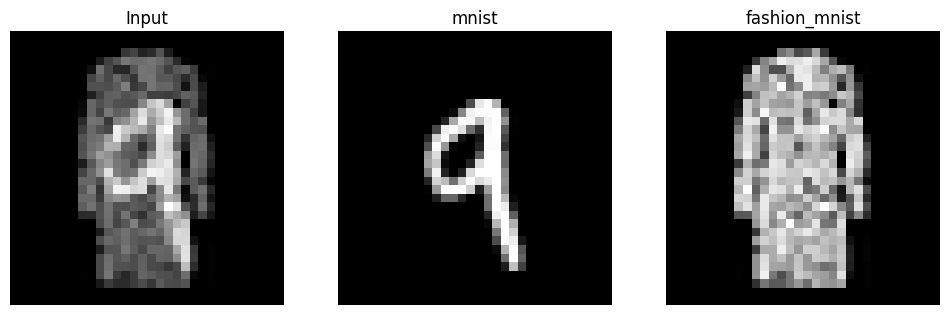

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


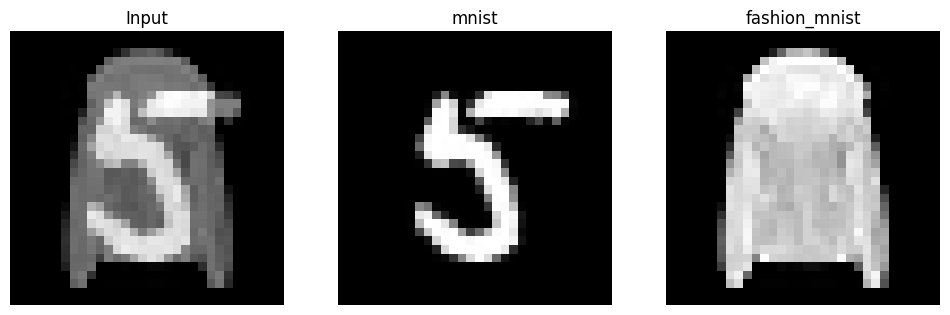

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


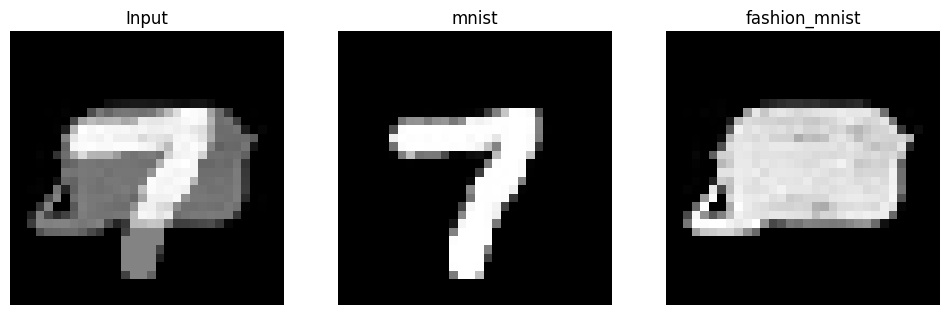

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


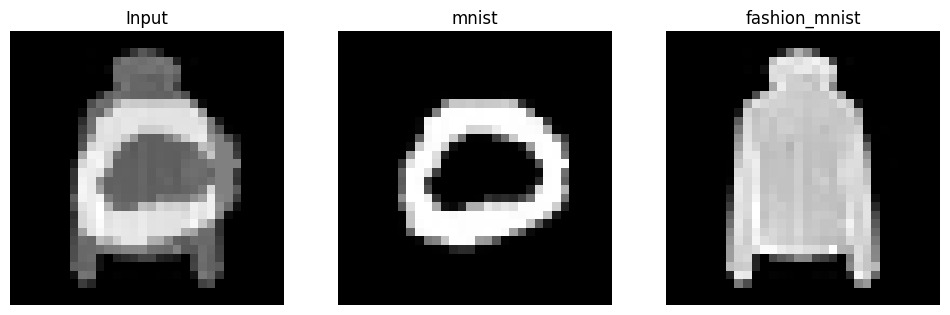

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


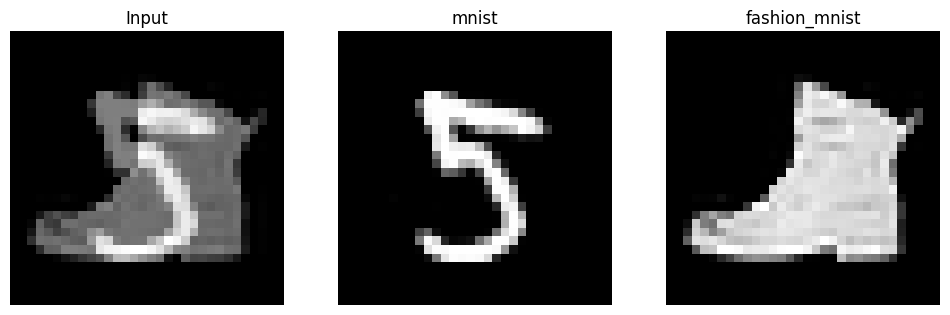

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


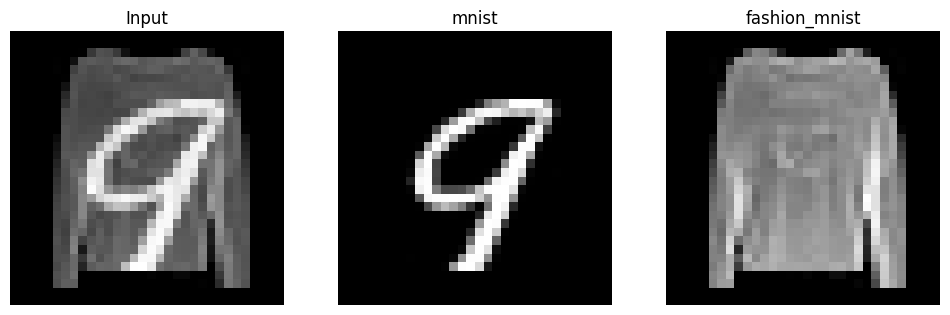

In [38]:
def test_with_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

for i in range(repeat_eval):
    x, _ = next(testgen)
    (y1, y2) = model.predict(x)
    test_with_images(x[0], y1[0], y2[0])